<a href="https://colab.research.google.com/github/Steriva/PINNs-pyTorch/blob/master/PINN_ODEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Network for parametric ODEs
This notebook implements the basic tools using *pyTorch* to build from scratch a PINN for an ODE, e. g.
\begin{equation}
\frac{d f}{dt}=R\cdot t(1-t)
\end{equation}
given $f(0)=1$. The package for Automatic Differentiation (AD) is used to compute derivatives (AD is actually what made neural networks so efficient and successful in the first place).

This notebook is based on [Mario Dagrada's Tutorial](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4).

At first, a PINN class is defined for the topology of the net: it it takes as input the number of layers (excluding input) and the hidden dimension of the layers, the activation is by default an hyperbolic tangent, even though it can be changed.

In [ ]:
!pip install pyDOE

In [2]:
import torch
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

A class which takes as input a list with the number of neurons per each layer is defined.

In [3]:
from torch import nn
from collections import OrderedDict

class NeuralNet(nn.Module):
    """Simple neural network accepting one feature as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """    
    def __init__(self, layers: list, act=nn.Tanh()):
        super(NeuralNet, self).__init__()

        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = nn.Sequential(layerDict)

    def forward(self, x):
        return self.layers(x)
        

## Logistic Equation
Let us consider the following ODE, a logistic equation
\begin{equation}
\frac{d f}{dt}=R\cdot t(1-t)
\end{equation}
given $f(0)=1$, the following functions are used to train a Neural Network considering $R=1$.

In [ ]:
from typing import Callable

def f(nn: NeuralNet, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: NeuralNet, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(
    nn: NeuralNet, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    interior_loss = df(nn, x) - 1. * x**2 * (1 - x)

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = f(nn, boundary) - 1.
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss, interior_loss.pow(2).mean(), boundary_loss ** 2


def train_model(
    nn: NeuralNet,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NeuralNet:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss, residual_loss, boundary_loss = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f'Iter {epoch+0:06} | Loss: {float(loss):.3e} | Residual: {float(residual_loss):.3e} | Boundary: {float(boundary_loss):.3e}')
            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)

Let us train this net considering 20 steps inside the domain, uniformly spaced.

In [ ]:
from functools import partial

domain = [0.0, 1.0]
x = torch.linspace(domain[0], domain[1], steps=20, requires_grad=True)
x = x.reshape(x.shape[0], 1)


layers = [1, 10, 10, 10, 1]
nn_approximator = NeuralNet(layers)
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
)

Iter 000000 | Loss: 9.880e-01 | Residual: 8.907e-03 | Boundary: 9.791e-01
Iter 001000 | Loss: 1.213e-03 | Residual: 1.213e-03 | Boundary: 4.106e-09
Iter 002000 | Loss: 8.854e-04 | Residual: 8.854e-04 | Boundary: 1.098e-09
Iter 003000 | Loss: 7.161e-04 | Residual: 7.161e-04 | Boundary: 1.879e-10
Iter 004000 | Loss: 6.562e-04 | Residual: 6.562e-04 | Boundary: 9.095e-13
Iter 005000 | Loss: 6.170e-04 | Residual: 6.170e-04 | Boundary: 4.299e-11
Iter 006000 | Loss: 5.801e-04 | Residual: 5.801e-04 | Boundary: 7.994e-11
Iter 007000 | Loss: 5.437e-04 | Residual: 5.437e-04 | Boundary: 1.126e-10
Iter 008000 | Loss: 5.072e-04 | Residual: 5.072e-04 | Boundary: 1.508e-10
Iter 009000 | Loss: 4.702e-04 | Residual: 4.702e-04 | Boundary: 1.912e-10
Iter 010000 | Loss: 4.323e-04 | Residual: 4.323e-04 | Boundary: 2.439e-10
Iter 011000 | Loss: 3.932e-04 | Residual: 3.932e-04 | Boundary: 2.988e-10
Iter 012000 | Loss: 3.526e-04 | Residual: 3.526e-04 | Boundary: 3.503e-10
Iter 013000 | Loss: 3.104e-04 | Residu

In the end, let us compare the NN solution which respect to a numerical calculation, for this simple case, also an analytical solution is possible.

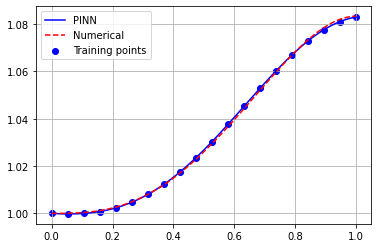

In [ ]:
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

# numeric solution
def logistic_eq_fn(x, y):
    return 1. * x**2 * (1 - x)

import time

numerical_time = time.time()
numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [1.], t_eval=x_eval.squeeze().detach().numpy()
)
numerical_time = time.time() - numerical_time

PINN_time = time.time()
f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)
PINN_time = time.time() - PINN_time

plt.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="b")

plt.plot(x_eval, f_final.detach().numpy(),'b', label='PINN')

plt.plot(x_eval, numeric_solution.y.T, 'r--', label = 'Numerical')

plt.legend()
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

### Class implementation
The previous setting will be included into a class for a more compact implementation.

In [4]:
class PINN_population():
    def __init__(self, IC, CollocationPts, layers):
        
        # data
        self.t0  = torch.zeros([1, 1]).to(device)
        self.IC  = torch.tensor(IC).float().to(device)
        self.t_f = torch.tensor(CollocationPts[:, 0:1], requires_grad=True).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = NeuralNet(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        
        self.iter = 0

        # Adam optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        return u_t - 1.0 * t * (1-t)
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.t0)
        f_pred = self.net_f(self.t_f)
        loss_u = torch.mean((self.IC - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 20 == 0:
            print(f'Iter {self.iter+0:06} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e}| Loss_f: {loss_f.item():.3e}')
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def trainAdam(self, epochs):

      for epoch in range(epochs+1):
        self.optimizer_Adam.zero_grad()

        # IC prediction
        u_pred = self.net_u(self.t0)

        # Residual prediction
        f_pred = self.net_f(self.t_f)

        # Compute loss function
        loss_u = torch.mean((self.IC - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        loss = loss_u + loss_f

        loss.backward()
        self.optimizer_Adam.step()
        if epoch % 1000 == 0:
            print(f'Iter {epoch+0:05} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e} | Loss_f: {loss_f.item():.3e}')
       
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
       
        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [7]:
from pyDOE import lhs
IC = 1.

lb = np.array([0])
ub = np.array([1])

X_f_train = lb + (ub-lb)*lhs(2, 25)

layers = [1, 10, 10, 1]
model = PINN_population(IC, X_f_train, layers)
model.trainAdam(3000)

Iter 00000 | Loss: 4.209e-01 | Loss_u: 3.226e-01 | Loss_f: 9.829e-02
Iter 01000 | Loss: 5.334e-03 | Loss_u: 5.202e-07 | Loss_f: 5.333e-03
Iter 02000 | Loss: 1.102e-04 | Loss_u: 8.185e-12 | Loss_f: 1.102e-04
Iter 03000 | Loss: 9.519e-05 | Loss_u: 1.036e-11 | Loss_f: 9.519e-05


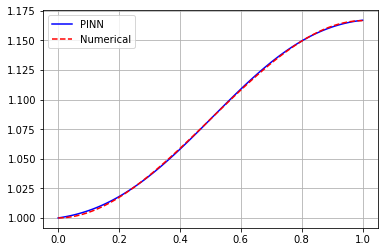

In [ ]:
t_eval = np.linspace(0,1,100)

# numeric solution
def logistic_eq_fn(x, y):
    return 1. * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [1.], t_eval=t_eval
)

pinn_prediction, _ = model.predict(t_eval.reshape(-1,1))

plt.plot(t_eval, pinn_prediction, 'b', label='PINN')
plt.plot(t_eval, numeric_solution.y.T, 'r--', label = 'Numerical')


plt.legend()
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

### Parametric version of the PINN
In the previous framework, the coefficient $R$ was supposed to be constant and equal to 1. We would like to see if we can train the NN to solve the parametric ODE.

In [ ]:
# the physics-guided neural network
class PINN_population():
    def __init__(self, IC, CollocationPts, layers):
        
        # data
        self.t0  = torch.zeros([len(CollocationPts), 1]).to(device)
        self.IC  = torch.tensor(IC).float().to(device)
        self.t_f = torch.tensor(CollocationPts[:, 0:1], requires_grad=True).float().to(device)
        self.R_f = torch.tensor(CollocationPts[:, 1:2], requires_grad=True).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = NeuralNet(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        
        self.iter = 0
        
    def net_u(self, t, R):  
        u = self.dnn(torch.cat([t, R], dim=1))
        return u
    
    def net_f(self, t, R):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t, R)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        return u_t - R * t * (1-t)
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.t0, self.R_f)
        f_pred = self.net_f(self.t_f, self.R_f)
        loss_u = torch.mean((self.IC - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 20 == 0:
            print(f'Iter {self.iter+0:06} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e}| Loss_f: {loss_f.item():.3e}')
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        R = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t, R)
        f = self.net_f(t, R)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

Let us train the net

In [ ]:
from pyDOE import lhs
IC = 1.

lb = np.array([0, 0.5])
ub = np.array([1, 1.5])

X_f_train = lb + (ub-lb)*lhs(2, 25)

layers = [2, 10, 10, 1]
model = PINN_population(IC, X_f_train, layers)
model.train()

Iter 000020 | Loss: 4.476e-03 | Loss_u: 1.806e-05| Loss_f: 4.458e-03
Iter 000040 | Loss: 6.653e-04 | Loss_u: 5.244e-05| Loss_f: 6.128e-04
Iter 000060 | Loss: 2.961e-04 | Loss_u: 1.794e-05| Loss_f: 2.781e-04
Iter 000080 | Loss: 5.872e-05 | Loss_u: 5.025e-06| Loss_f: 5.370e-05
Iter 000100 | Loss: 4.318e-05 | Loss_u: 6.430e-06| Loss_f: 3.675e-05
Iter 000120 | Loss: 3.077e-05 | Loss_u: 5.996e-06| Loss_f: 2.477e-05
Iter 000140 | Loss: 1.297e-05 | Loss_u: 5.924e-06| Loss_f: 7.048e-06
Iter 000160 | Loss: 8.295e-06 | Loss_u: 3.221e-06| Loss_f: 5.074e-06
Iter 000180 | Loss: 2.207e-06 | Loss_u: 4.880e-08| Loss_f: 2.158e-06
Iter 000200 | Loss: 1.854e-06 | Loss_u: 2.420e-08| Loss_f: 1.829e-06
Iter 000220 | Loss: 1.303e-06 | Loss_u: 2.924e-08| Loss_f: 1.274e-06


Then, the prediction is compared with the numerical solution using scipy package.

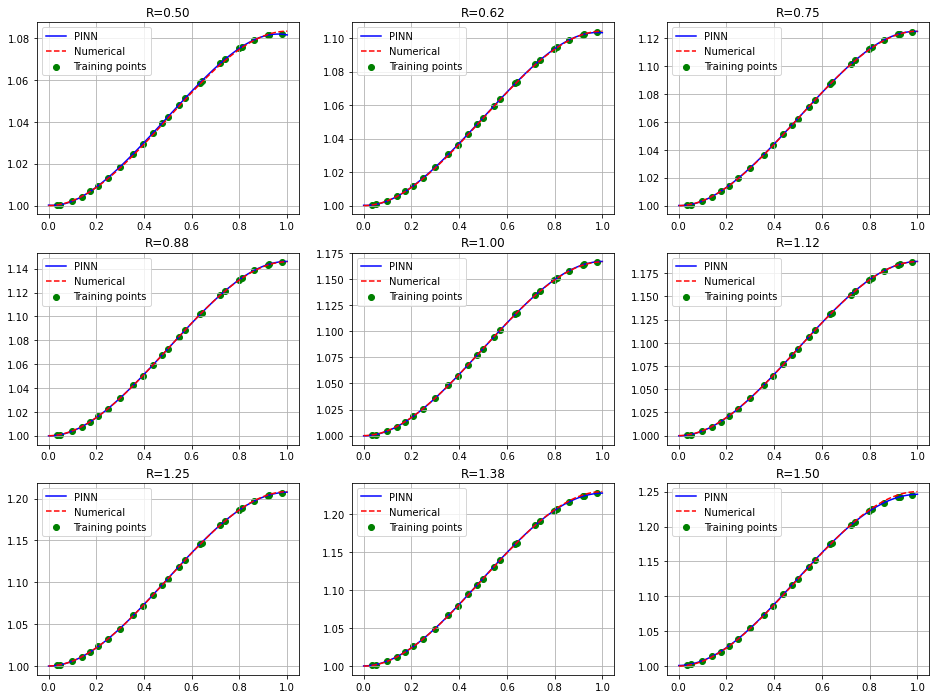

In [ ]:
xTest = np.linspace(0, 1, 100)
RTestSet = np.linspace(0.5, 1.5, 9)

def logistic_eq_fn(x, y, R):
    return R * x * (1 - x)

checkPINN = plt.figure( figsize = (16,12) )

for mu in range(len(RTestSet)):
  R_0 = RTestSet[mu]
  R_in_NN = R_0 * np.ones((100,1))

  X_star = np.vstack([xTest, R_in_NN.flatten()]).T

  domain = [0.0, 1.0]
  numeric_solution = solve_ivp(
      logistic_eq_fn, domain, [1.], args = ([R_0]), t_eval=xTest
  )

  u_pred, f_pred = model.predict(X_star)

  Pt_Train = np.vstack([X_f_train[:,0], R_in_NN[:len(X_f_train[:,0])].flatten()]).T
  u_TrainPts, _= model.predict(Pt_Train)

  plt.subplot(3,3,mu+1)
  plt.scatter(X_f_train[:,0], u_TrainPts, label="Training points", color="g")
  plt.plot(xTest, u_pred,'b', label='PINN')
  plt.plot(xTest, numeric_solution.y.T, 'r--', label = 'Numerical')

  plt.legend()
  plt.title('R={:.2f}'.format(R_0))
  plt.grid(which='major',linestyle='-')
  plt.grid(which='minor',linestyle='--')

## System of ODEs
Let us consider the following ODEs system
\begin{equation}
\left\{
  \begin{array}{ll}
    \dot{x} = x - 4 y & x(0) = 1\\
    \dot{y} = 2x + y & y(0) = -1
  \end{array}
\right.
\end{equation}


In [8]:
class PINN_ODEsys():
    def __init__(self, IC, CollocationPts, layers, matrix):
        
        # data
        self.t0  = torch.zeros([1, 1]).to(device)
        self.IC  = torch.tensor(IC).float().to(device)
        self.t_f = torch.tensor(CollocationPts[:, 0:1], requires_grad=True).float().to(device)
        
        self.layers = layers
        
        # ODE matrix
        self.matrix = matrix

        # deep neural networks
        self.dnn = NeuralNet(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        
        self.iter = 0

        # Adam optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t)

        f_list = list()

        for ii in range(2):
          x = u[:, ii:ii+1]

          matrixTorch = torch.tensor(self.matrix[ii, :].T).float().to(device)
          x_t = torch.autograd.grad(
              x, t, 
              grad_outputs=torch.ones_like(x),
              retain_graph=True,
              create_graph=True
          )[0]
          RHS = torch.reshape(torch.matmul(u, matrixTorch), x_t.shape)
          f_list.append( x_t - RHS )
        return f_list

    def trainAdam(self, epochs):

      for epoch in range(epochs+1):
        self.optimizer_Adam.zero_grad()

        # IC prediction
        u_pred = self.net_u(self.t0)

        # Residual prediction
        f_pred = model.net_f(model.t_f)              

        # Compute loss function
        loss_u = torch.mean((self.IC - u_pred) ** 2)

        loss_f = list() 
        for ii in range(len(f_pred)):
          loss_f.append(torch.mean(f_pred[ii]**2))

        loss_f = sum(loss_f)
        loss = loss_u + loss_f

        loss.backward()
        self.optimizer_Adam.step()
        if epoch % 1000 == 0:
            print(f'Iter {epoch+0:05} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e} | loss_f: {loss_f.item():.3e}')
       
    def predict(self, X):
        input = torch.tensor(X, requires_grad=True).float().to(device)
       
        self.dnn.eval()
        u = self.net_u(input)
        u = u.detach().cpu().numpy()
        x = u[:, 0:1]
        y = u[:, 1:2]

        f_x, f_y = self.net_f(input)
        f_x = f_x.detach().cpu().numpy()
        f_y = f_y.detach().cpu().numpy()
        return x, y, f_x, f_y

from pyDOE import lhs
IC = np.reshape(np.array([1., -10.]), (1,2))

lb = np.array([0])
ub = np.array([1])

X_f_train = lb + (ub-lb)*lhs(1, 50)

matrix = np.array([
    [1., -4], [2., 1.]
])

layers = [1, 10, 2]
model = PINN_ODEsys(IC, X_f_train, layers, matrix)
model.trainAdam(10000)

Iter 00000 | Loss: 5.535e+01 | Loss_u: 5.429e+01 | loss_f: 1.057e+00
Iter 01000 | Loss: 4.213e+01 | Loss_u: 3.663e+01 | loss_f: 5.499e+00
Iter 02000 | Loss: 3.543e+01 | Loss_u: 2.860e+01 | loss_f: 6.829e+00
Iter 03000 | Loss: 2.339e+01 | Loss_u: 1.829e+01 | loss_f: 5.097e+00
Iter 04000 | Loss: 1.219e+01 | Loss_u: 9.088e+00 | loss_f: 3.106e+00
Iter 05000 | Loss: 5.200e+00 | Loss_u: 3.621e+00 | loss_f: 1.579e+00
Iter 06000 | Loss: 2.019e+00 | Loss_u: 1.089e+00 | loss_f: 9.299e-01
Iter 07000 | Loss: 9.222e-01 | Loss_u: 3.118e-01 | loss_f: 6.104e-01
Iter 08000 | Loss: 3.391e-01 | Loss_u: 7.014e-02 | loss_f: 2.690e-01
Iter 09000 | Loss: 7.575e-02 | Loss_u: 8.929e-03 | loss_f: 6.682e-02
Iter 10000 | Loss: 3.064e-02 | Loss_u: 9.147e-04 | loss_f: 2.972e-02


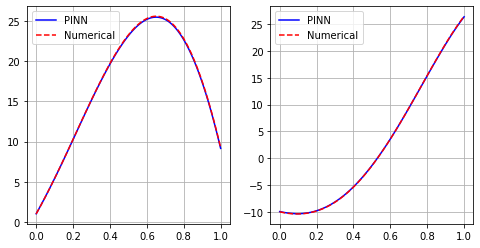

In [9]:
def simpleODEsys(x, y):
    return np.dot(matrix, y)

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-10
integrator_keywords['method'] = 'RK45'
integrator_keywords['atol'] = 1e-12

simpleODE = solve_ivp(simpleODEsys, (0,1), IC.flatten(), **integrator_keywords, dense_output=True)

t_eval = np.linspace(0,1, 100)
x_num = simpleODE.sol(t_eval).T[:, 0]
y_num = simpleODE.sol(t_eval).T[:, 1]

x_PINN, y_PINN, _, _ = model.predict(t_eval.reshape(-1,1))

plt.figure( figsize = (8, 4) )
plt.subplot(1,2,1)
plt.plot(t_eval, x_PINN, 'b', label = 'PINN')
plt.plot(t_eval, x_num, 'r--', label = 'Numerical')
plt.legend()
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.subplot(1,2,2)
plt.plot(t_eval, y_PINN, 'b', label = 'PINN')
plt.plot(t_eval, y_num, 'r--', label = 'Numerical')
plt.legend()
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

## Non-Linear ODE
In every example, that has been faced before the IC was in general "small", thus it didn't cause problems during the training. However, if the solution has an IC "large", it may be difficult to reduce the loss function, especially for non-linear problems.

Let us consider the following ODE
\begin{equation}
\left\{
  \begin{array}{ll}
    \frac{d u}{dt} = f(u,t)\\ u(0) = u_0
  \end{array}
\right.
\end{equation}
An approximate solution of this problem is the following
\begin{equation}
  u_{NN}(t) = u_0 + t \cdot \Phi_{NN}(t) 
\end{equation}
in which $\Phi_{NN}(t)$ represents the output of the NN given the input $t$. In this way, the IC is always respected! The loss function is only given by the residual, i.e.
\begin{equation}
\mathcal{L} = \left\|\frac{d u_{NN}}{dt} - f(u_{NN},t)\right\|
\end{equation}

The following example will focus on the following ODE
\begin{equation}
\left\{
  \begin{array}{ll}
    \frac{d u}{dt} =- u^2\\ u(0) = u_0
  \end{array}
\right.
\end{equation}
If $|u_0|>>1$, it may be useful to normalise the loss function with respect to it, to enhance the training of the NN, i.e.
\begin{equation}
\mathcal{L}^* = \left\|\frac{1}{u_0}\cdot\left[\frac{d u_{NN}}{dt} - f(u_{NN},t)\right]\right\|
\end{equation}

In [78]:
class PINN_nonLinODE():
    def __init__(self, t0, IC, CollocationPts, layers, gamma):
        
        # data
        self.t0  = torch.tensor(t0).float().to(device)
        self.IC  = torch.tensor(IC).float().to(device)
        self.gamma = gamma

        self.t_f = torch.tensor(CollocationPts[:, 0:1], requires_grad=True).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = NeuralNet(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        
        self.iter = 0

        # Adam optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        
    def net_u(self, t):
        # The output is u0 + (t-t0) * net_u(t)  
        u = self.dnn(t)
        return self.IC + (t-self.t0) * u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t)

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        return (u_t + u) / self.IC

    def trainAdam(self, epochs):

      for epoch in range(epochs+1):
        self.optimizer_Adam.zero_grad()

        # Residual prediction
        f_pred = model.net_f(model.t_f)              

        loss = torch.mean(f_pred**2)

        loss.backward()
        self.optimizer_Adam.step()
        if epoch % 1000 == 0:
            print(f'Iter {epoch+0:05} | Loss: {loss.item():.3e}')
       
    def predict(self, X):
        input = torch.tensor(X, requires_grad=True).float().to(device)
       
        self.dnn.eval()
        u = self.net_u(input).detach().cpu().numpy()

        f = self.net_f(input).detach().cpu().numpy()
        return u, f

In this case, a non-parametric version will be considered then $\gamma = 0.5$ and $u_0 = 1$.

In [87]:
gamma = 0.5
u0 = 100

from pyDOE import lhs

lb = np.array([0])
ub = np.array([1])

X_f_train = lb + (ub-lb)*lhs(1, 50)

layers = [1, 20, 15, 10, 1]
model = PINN_nonLinODE(0., u0, X_f_train, layers, gamma)

model.trainAdam(20000)

Iter 00000 | Loss: 1.004e+00
Iter 01000 | Loss: 6.724e-01
Iter 02000 | Loss: 4.538e-01
Iter 03000 | Loss: 2.924e-01
Iter 04000 | Loss: 1.779e-01
Iter 05000 | Loss: 1.030e-01
Iter 06000 | Loss: 6.035e-02
Iter 07000 | Loss: 4.147e-02
Iter 08000 | Loss: 3.616e-02
Iter 09000 | Loss: 3.551e-02
Iter 10000 | Loss: 3.549e-02
Iter 11000 | Loss: 3.549e-02
Iter 12000 | Loss: 3.549e-02
Iter 13000 | Loss: 3.549e-02
Iter 14000 | Loss: 3.549e-02
Iter 15000 | Loss: 3.549e-02
Iter 16000 | Loss: 3.549e-02
Iter 17000 | Loss: 3.549e-02
Iter 18000 | Loss: 9.310e-03
Iter 19000 | Loss: 2.190e-03
Iter 20000 | Loss: 7.223e-04


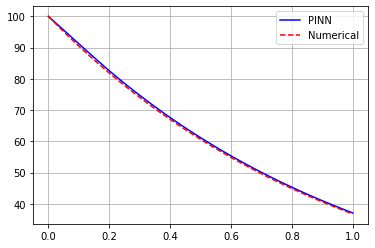

In [88]:
def nonLinODE(t, u, gamma):
  return -u

tEval = np.linspace(0,1,100)

nonLinODE_numerical = solve_ivp(nonLinODE, (0,1), np.array([u0]), args=([gamma]), **integrator_keywords, dense_output=True)

u_NN, _ = model.predict(tEval.reshape(-1,1))
plt.plot(tEval, u_NN, 'b', label = 'PINN')
plt.plot(tEval, nonLinODE_numerical.sol(tEval).T, 'r--', label='Numerical')
plt.legend()
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')